# **Import libraries**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import warnings

#from autosklearn.classification import AutoSklearnClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from numpy.random import normal, rand, seed
from warnings import catch_warnings, simplefilter
from scipy.stats import norm
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")

# **Load Students' Dropout and Academic Success data**

In [20]:
df = pd.read_csv('https://archive.ics.uci.edu/static/public/697/data.csv')
print("Dataset Head:")
print(df.head())

Dataset Head:
   Marital Status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                       

## Segregate data

In [21]:
# Segregate the data base on its type
cat = [
    "Marital Status", 
    "Application mode", 
    "Course",
    "Previous qualification", 
    "Nacionality", 
    "Mother's qualification", 
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]

bin = [
    "Daytime/evening attendance",
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder",
    "International"
]

ord = [
    "Application order"
]

df_cat = df[cat + ['Target']]
df_bin = df[bin + ['Target']]
df_num = df.drop(columns=cat + bin)

# Preprocessing

Encode data base on its type and perform balance split data stratified by the labels with 70% allocated to training, 15% for validation, and 15% for testing.

In [22]:
# Encode variables
he = OneHotEncoder()
sc = StandardScaler()

# Encode categorical variables and scale continuous variables
x_cat = he.fit_transform(df[cat])
x_num = df.drop(columns=cat + bin + ['Target'])
x_num = sc.fit_transform(x_num)

# Combine encoded variables
x_bin = df[bin].to_numpy()
x = np.concatenate([x_cat.toarray(), x_bin, x_num], axis=1)
y = df['Target'].to_numpy()

# Create training, validation, and test set
X_train, X_2, y_train, y_2 = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_2, y_2, test_size=0.5, random_state=0, stratify=y_2)


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3096, 247)
(664, 247)
(664, 247)


In [23]:
# Store column names
cat_names = list(he.get_feature_names_out(cat))
bin_names = list(bin)
num_names = list((df_num.iloc[:, :-1]).columns)
col_names = cat_names+bin_names+num_names
print(col_names)
X = pd.DataFrame(
    data=x,
    columns=col_names
)

['Marital Status_1', 'Marital Status_2', 'Marital Status_3', 'Marital Status_4', 'Marital Status_5', 'Marital Status_6', 'Application mode_1', 'Application mode_2', 'Application mode_5', 'Application mode_7', 'Application mode_10', 'Application mode_15', 'Application mode_16', 'Application mode_17', 'Application mode_18', 'Application mode_26', 'Application mode_27', 'Application mode_39', 'Application mode_42', 'Application mode_43', 'Application mode_44', 'Application mode_51', 'Application mode_53', 'Application mode_57', 'Course_33', 'Course_171', 'Course_8014', 'Course_9003', 'Course_9070', 'Course_9085', 'Course_9119', 'Course_9130', 'Course_9147', 'Course_9238', 'Course_9254', 'Course_9500', 'Course_9556', 'Course_9670', 'Course_9773', 'Course_9853', 'Course_9991', 'Previous qualification_1', 'Previous qualification_2', 'Previous qualification_3', 'Previous qualification_4', 'Previous qualification_5', 'Previous qualification_6', 'Previous qualification_9', 'Previous qualificati

# AutoML

## Implement auto-sklearn

Final Ensemble Models
          rank  ensemble_weight               type      cost   duration
model_id                                                               
2            1             0.52      random_forest  0.246575   5.209003
9            2             0.08      random_forest  0.251468   6.170352
8            3             0.18      random_forest  0.256360   8.966704
10           4             0.10  gradient_boosting  0.263209   3.080715
11           5             0.08                mlp  0.294521  11.477398
3            6             0.04         libsvm_svc  0.316047   2.007565

Classification Report on Test Set


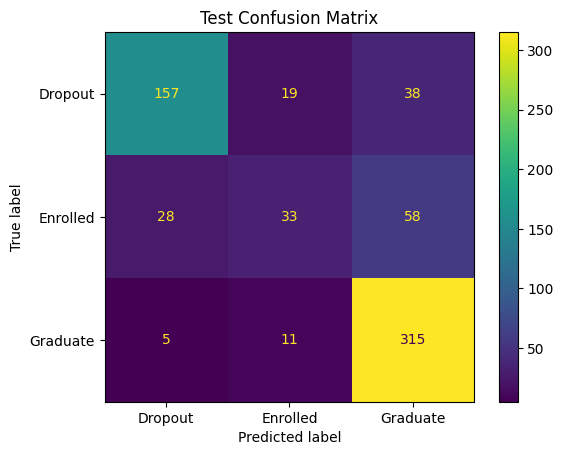

              precision    recall  f1-score   support

     Dropout     0.8263    0.7336    0.7772       214
    Enrolled     0.5238    0.2773    0.3626       119
    Graduate     0.7664    0.9517    0.8491       331

    accuracy                         0.7605       664
   macro avg     0.7055    0.6542    0.6630       664
weighted avg     0.7422    0.7605    0.7387       664



In [6]:
automl = AutoSklearnClassifier(
    time_left_for_this_task=10,
    per_run_time_limit=2
)

# Fit the model
automl.fit(X_train, y_train)

# Present the models
print("Final Ensemble Models")
print(automl.leaderboard())

print("======================================")

# Evaluate on the test split
y_pred = automl.predict(X_test)
print("\nClassification Report on Test Set")
cfm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ["Dropout", "Enrolled", "Graduate"])
cm_display.plot()
plt.title('Test Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred,digits=4))


## Permutation feature importance

In [ ]:
train_result = permutation_importance(automl, X_train, y_train, n_repeats=10, random_state=42)
test_results = permutation_importance(automl, X_test, y_test, n_repeats=10, random_state=42)


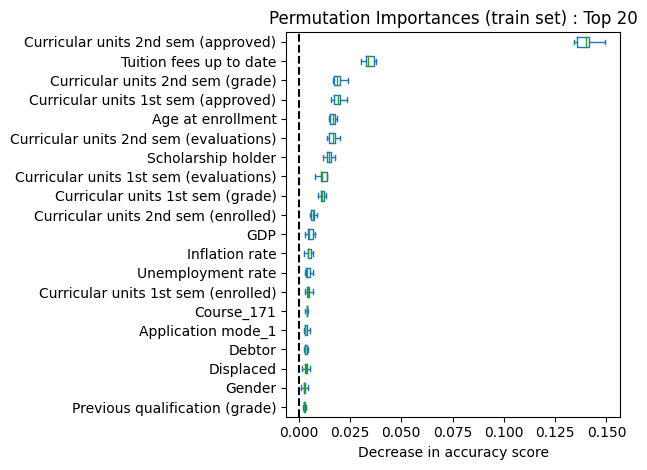

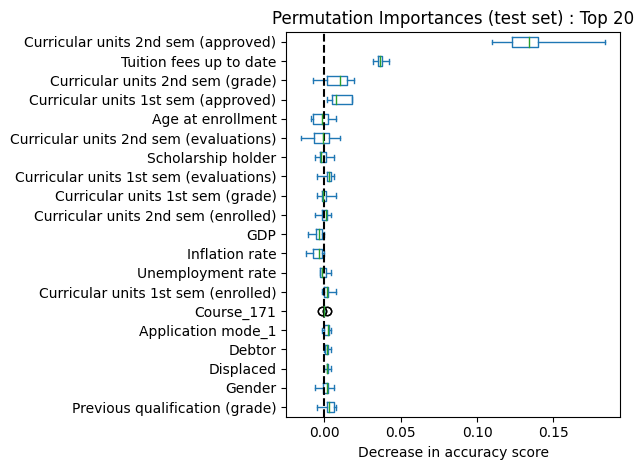

In [56]:
sorted_importances_idx = train_result.importances_mean.argsort()
top10_idx = sorted_importances_idx[::-1][:20]

train_importances = pd.DataFrame(
    train_result.importances[top10_idx].T,
    columns=X.columns[top10_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[top10_idx].T,
    columns=X.columns[top10_idx],
)
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set) : Top 20")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.invert_yaxis()
    ax.figure.tight_layout()

# Bayesian optimized model

Implement logistic regression (by default for multicall: OVR) using full feature space and L2 regularization.

## Logistic regregression 

### Develop optimization algorithm

In [24]:
# Define the surrogate function
model = GaussianProcessRegressor(kernel=RBF(length_scale=0.01), 
                                 normalize_y=False, 
                                 n_restarts_optimizer=10,
                                 alpha=0.02**2,
                                 random_state=0)

seed(5)
# catch any warning generated when making a prediction
with catch_warnings():
    # ignore generated warnings
    simplefilter("ignore")

def plot_surrogate_acquisition(model, feat_fine, X, y, make_plot):
    # model:  contains the fitted GPR
    # feat_fine: contains finely separated points
    # X:      contains the X samples from the objective func.
    # y:      contains the objective function values at X
    
    y_fine_pred, y_fine_std = model.predict(feat_fine, return_std=True)
    y_pred, y_std = model.predict(feat_fine, return_std=True)

    xi = 0.02   # Degree of exploration
    
    best = max(y_fine_pred)
    probs = norm.cdf((y_fine_pred - best - xi) / (y_fine_std+1E-9))
    next_X = feat_fine[np.argmax(probs,0)]
    
    if make_plot == 1:
        # Plot the surrogate model and the samples
        plt.figure(figsize=(7,7))
        plt.subplot(2,1,1)
        plt.scatter(X, y, 20, 'b', label='Sampled points')
        plt.plot(feat_fine, y_fine_pred, 'b', lw=0.8, label='GP mean')
        plt.fill_between(
            feat_fine.ravel(),
            y_fine_pred - y_fine_std,
            y_fine_pred + y_fine_std,
            color='b',
            alpha=0.1,
            label='GP 1-std.dev.'
        )
        plt.grid()
        plt.title(f"After {len(y)} samples")
        plt.legend(loc='best')
    
        # Plot the acquisition function: Probability of Improvement
        plt.subplot(2,1,2)
        plt.plot(feat_fine, probs, 'm', lw=2)
        plt.ylabel('Probability of Improvement')
        plt.scatter(next_X,max(probs),25,'m',edgecolor='k')
        plt.grid()
    
    return next_X

# Build objective function for training
def logreg(C, X_train,y_train,X_val,y_val):
    # Create the model
    model = LogisticRegression(C=C, random_state=0, solver='newton-cg', max_iter=1000,penalty='l2')
    model.fit(X_train, y_train)
    
    # Validation model
    val_rep = classification_report(y_val, model.predict(X_val), output_dict=True)
    val_res = pd.DataFrame(val_rep).T
    val_weighted_avg = val_res.loc['weighted avg']
    
    return val_weighted_avg['f1-score']

### Initialize hyperparameter value

In [47]:
# Initialize the surrogate model
feat_min = 1
feat_max = 100
feat_fine = np.linspace(feat_min, feat_max, 10000).reshape(-1, 1)
initial_samples = 10
feat_init = (rand(initial_samples) * (feat_max - feat_min) + feat_min).astype(float)

# Generate initial samples
feat = []
y_feat = []
for i in range(initial_samples):
    feat.append(feat_init[i])
    y_feat.append(logreg(feat_init[i], X_train,y_train,X_val,y_val))
feat = np.array(feat).reshape(-1, 1)
y_feat = np.array(y_feat).reshape(-1, 1)
print("Initial samples:")
print("feat:", feat)
print("y_feat:", y_feat)

Initial samples:
feat: [[45.21417496]
 [80.24716565]
 [ 3.01874647]
 [57.68924623]
 [41.72697796]
 [98.52854297]
 [80.33875151]
 [ 6.34224811]
 [19.85729957]
 [45.78946574]]
y_feat: [[0.7470134 ]
 [0.74391371]
 [0.75506295]
 [0.7470134 ]
 [0.7470134 ]
 [0.74391371]
 [0.74391371]
 [0.75145246]
 [0.75299166]
 [0.7470134 ]]


### Search for optimized hyperparameter

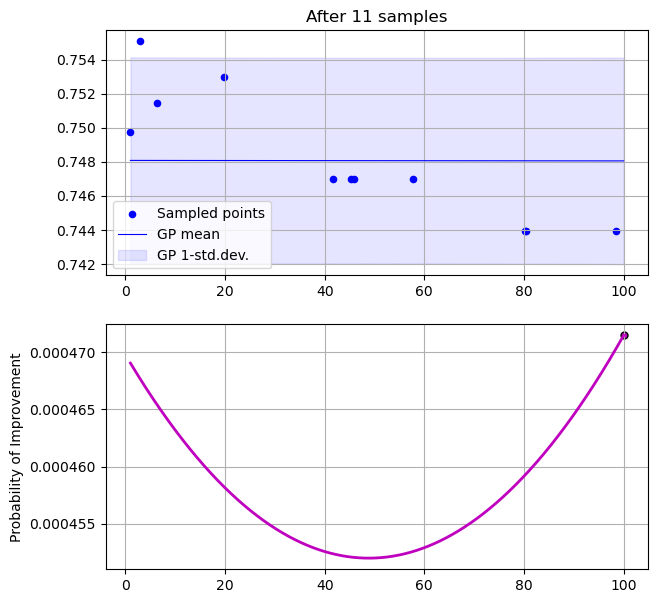

Sample 12: 100.0


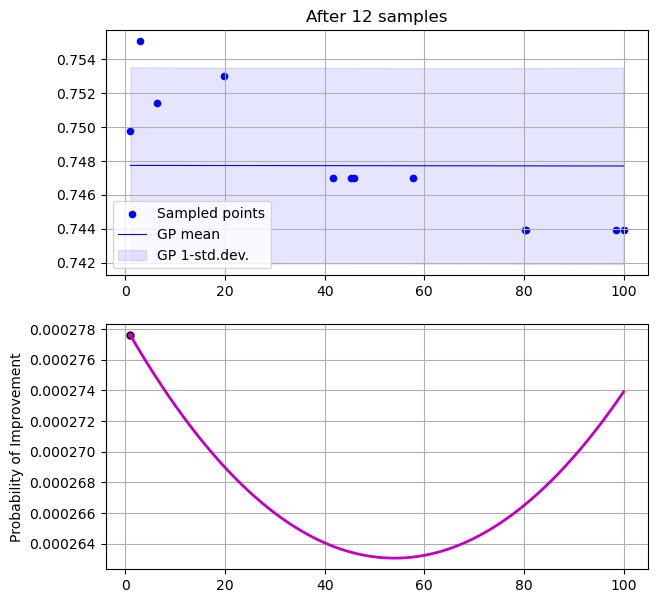

Sample 13: 1.0


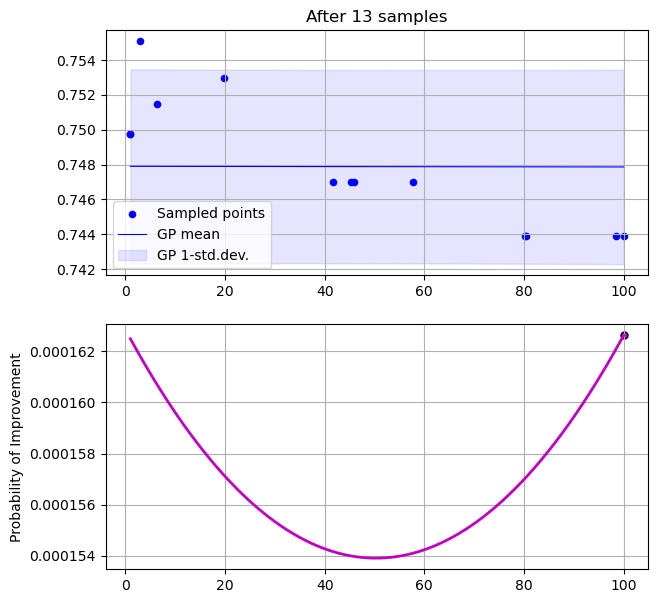

Sample 14: 100.0


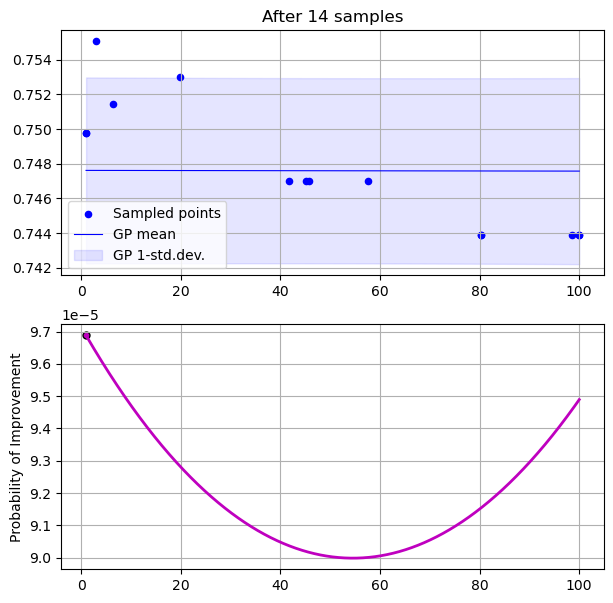

Sample 15: 1.0


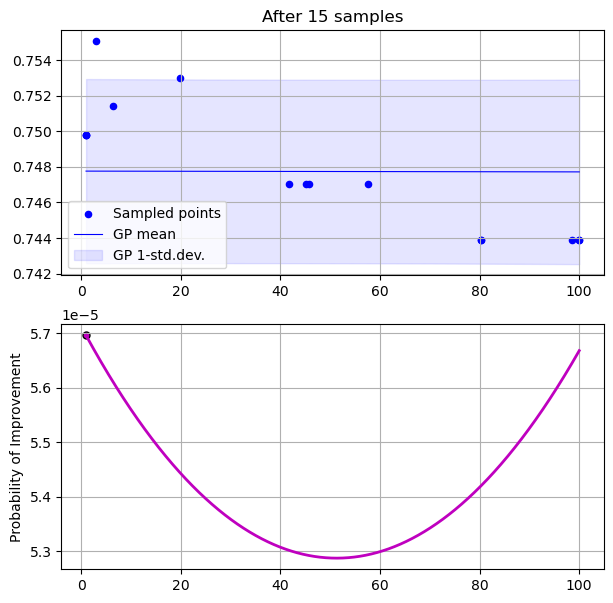

Sample 16: 1.0


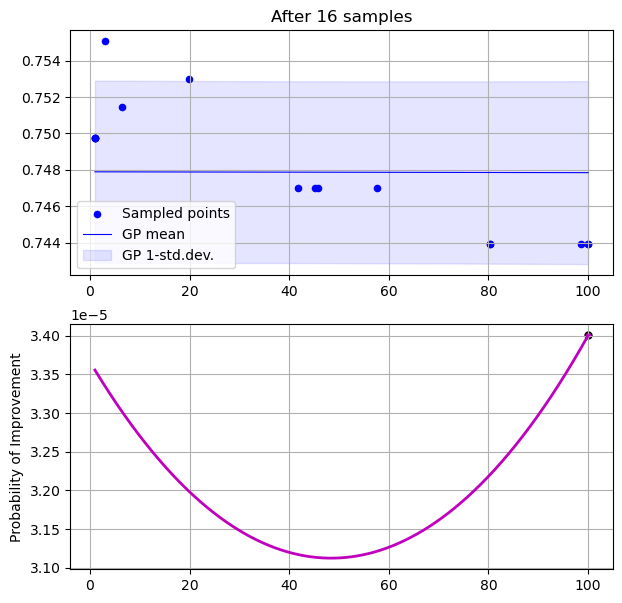

Sample 17: 100.0


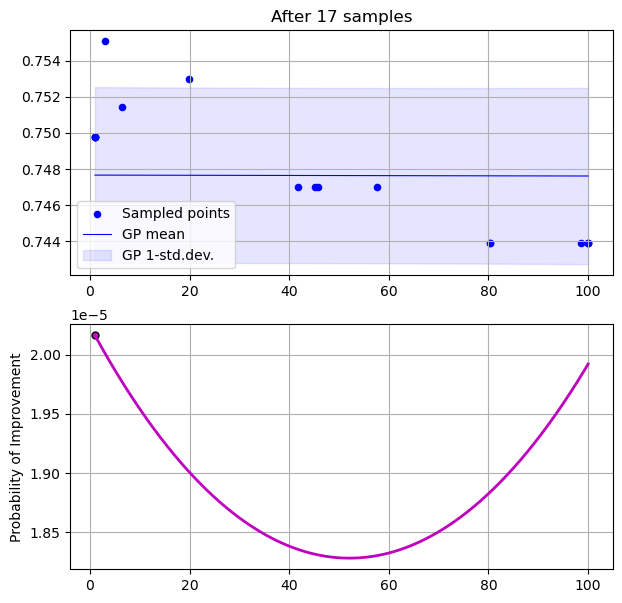

Sample 18: 1.0


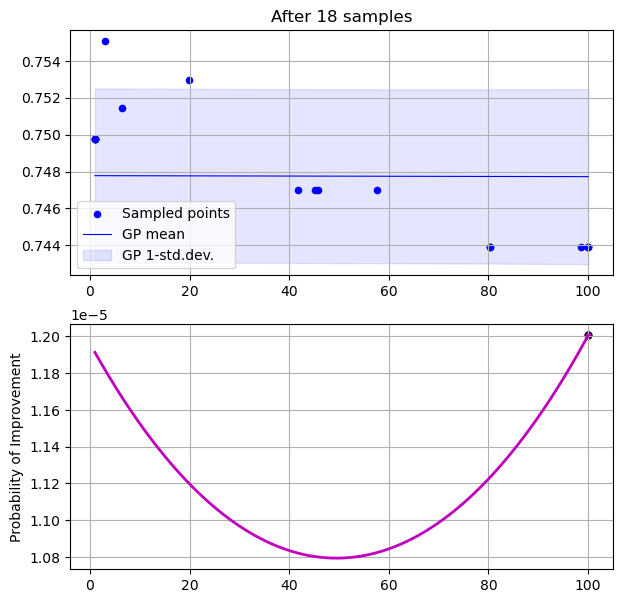

Sample 19: 100.0


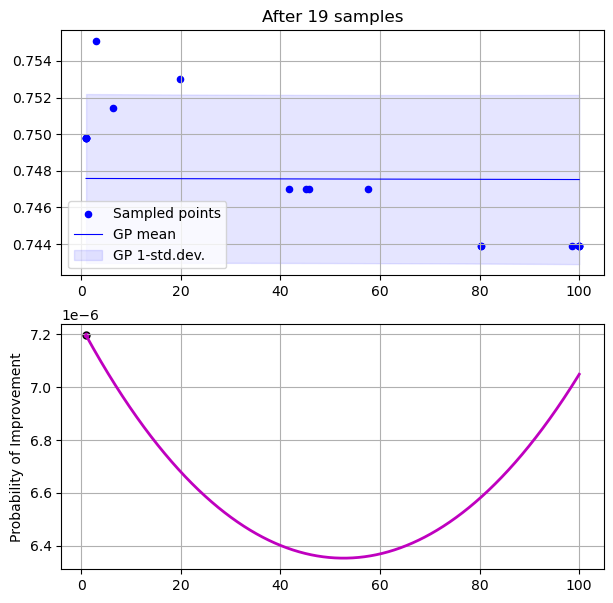

Sample 20: 1.0


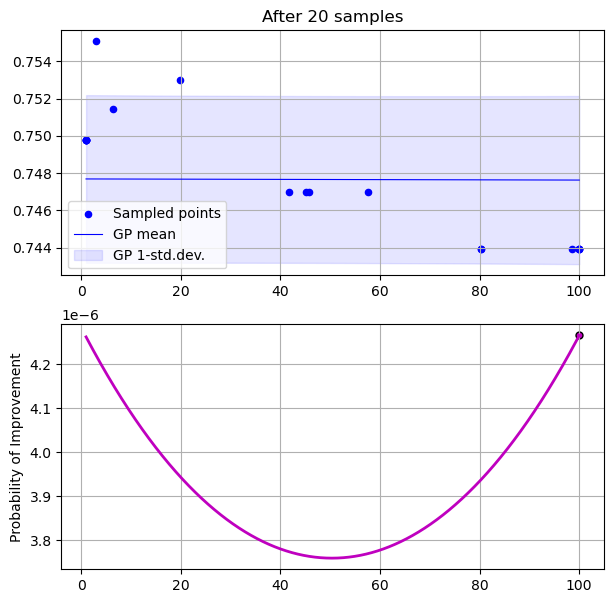

Sample 21: 100.0
Execution time: 7.02695107460022 sec


In [48]:
start = time()

max_iter = 20
for i in range(0, max_iter - initial_samples):
    feat = np.append(feat, next_X.item())
    y_feat = np.append(y_feat, next_Y)
    feat, y_feat = feat.reshape(-1, 1), y_feat.reshape(-1, 1)
    model.fit(feat, y_feat)
    next_X = plot_surrogate_acquisition(model, feat_fine, feat, y_feat, 1)
    next_Y = logreg(next_X.item(), X_train, y_train, X_val, y_val)
    plt.show() 
    print(f"Sample {initial_samples+i+2}: {next_X.item()}")

print(f"Execution time: {time()-start} sec")

### Test model with optimized hyperparameter

Optimized unit: 100.0
Training accuracy: 0.81
Validation accuracy: 0.75
Test accuracy: 0.78


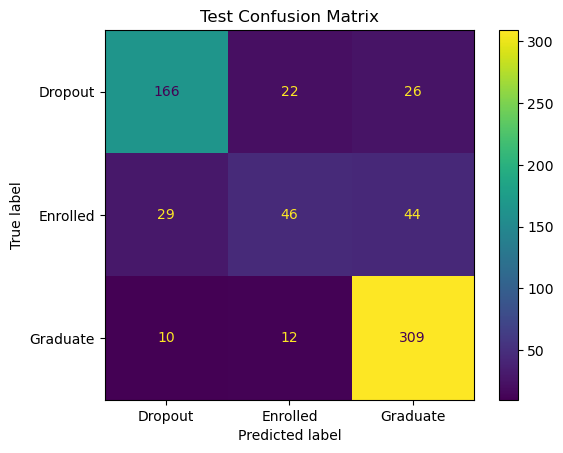

              precision    recall  f1-score   support

     Dropout     0.8098    0.7757    0.7924       214
    Enrolled     0.5750    0.3866    0.4623       119
    Graduate     0.8153    0.9335    0.8704       331

    accuracy                         0.7846       664
   macro avg     0.7334    0.6986    0.7084       664
weighted avg     0.7704    0.7846    0.7721       664



In [49]:
# Store optimizied hyperparameters
opt_C = next_X.item()
print(f"Optimized unit: {opt_C}")

# Train a model with optimized hyperparameter
mdl = LogisticRegression(C=opt_C, random_state=0, solver='newton-cg', max_iter=1000,penalty='l2').fit(X_train, y_train)

# Evaluate the model
train_acc = mdl.score(X_train, y_train)
val_acc = mdl.score(X_val, y_val)
test_acc = mdl.score(X_test, y_test)

y_pred = mdl.predict(X_test)
report = classification_report(y_test, y_pred, digits=4)

print(f"Training accuracy: {train_acc:.2f}")
print(f"Validation accuracy: {val_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

cfm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = ["Dropout", "Enrolled", "Graduate"])
cm_display.plot()
plt.title('Test Confusion Matrix')
plt.show()

print(report)

## Permutation Feature importance

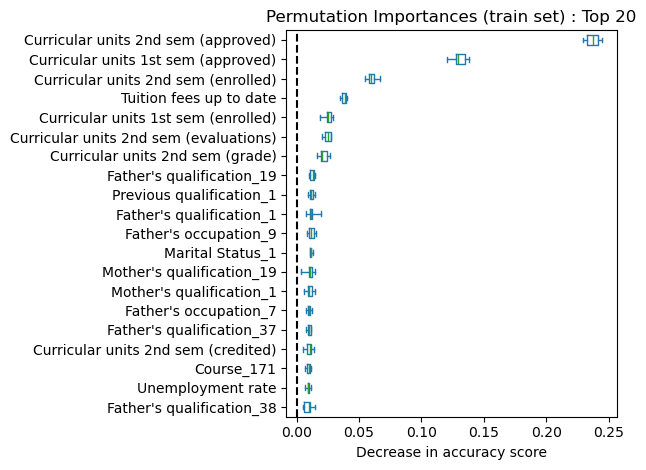

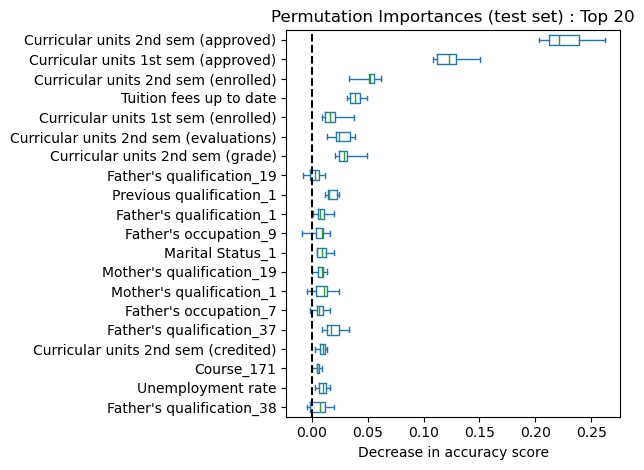

In [50]:
train_result = permutation_importance(mdl, X_train, y_train, n_repeats=10, random_state=42)
test_results = permutation_importance(mdl, X_test, y_test, n_repeats=10, random_state=42)
sorted_importances_idx = train_result.importances_mean.argsort()
top10_idx = sorted_importances_idx[::-1][:20]

train_importances = pd.DataFrame(
    train_result.importances[top10_idx].T,
    columns=X.columns[top10_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[top10_idx].T,
    columns=X.columns[top10_idx],
)
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set) : Top 20")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.invert_yaxis()
    ax.figure.tight_layout()


# Conclusion

As a result of this exercise, the optimized L2 regularized logistic regression model using the full feature space yield higher weighted f1 score compared to the Auto-sklearn algorithm that build an ensemble, with a 3 percentage point difference. In terms of feature importance, both models have similar variables that contributed largely to the accuracy score. Notably, the Auto-sklearn yielded important feature that are somewhat external to the examples after the curricular related features while the optimized L2 regulaized logistic regression model yielded mostly household related features as important. Lastly, given the processing in base machines, this exercise resulted to better processing time for the optimized model, especially in the permutation importance process.